<div,align=right>Lukas Blecher, Christopher Lueken-Winkels</div>
# Exercise 5


In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Constructing the matrix X

In [48]:
def construct_X(M, alphas, Np = None):
    '''
    M: resulting tomogram size D in one dimension (D=MxM) 
    alphas: list of No angles in degrees
    Np: sensor resolution (optional)
    returns X of shape (Np*No)xD
    '''
    #convert to numpy array and into radian
    alphas=np.array(alphas)*np.pi/180
    #in case Np is not given we will select one large enough to fit the diagonal of the image beta
    if Np==None:
        Np=np.ceil(np.sqrt(2)*M)
        if Np%2==0: #Np is even
            Np+=1
    
    N=len(alphas)*Np #response vector size
    D=M*M
    #create koordinate matrix C of the ceter of each pixel measured from the center of the image
    
    #"x" distance
    C_0 = np.mod(np.arange(D),M) - (M - 1)/2
    #"y" distance
    C_1 = np.floor_divide(np.arange(D),M) - (M - 1)/2
    #merge for C
    C = np.array([C_0,C_1]).T
    
    #now we compute the euclidean norm of the coordinates
    norm = np.sqrt(np.sum(np.square(C),axis = 1)) #array of length D
    #compute a matrix of shape (No,D) with the sign indicating in which direction the distance should be travelled
    prefactor = np.sign(np.sum(np.multiply(C[:,None],np.array([np.cos(alphas),np.sin(alphas)]).T),axis=2)).T
    
    #compute the translation along the sensor starting from the middle
    translation = np.outer(np.sin(alphas), norm) #has shape (No,D)

    #this is now projected on the senor using the position of the center as reference
    sensorpos = (Np - 1)/ 2 + np.multiply(translation, prefactor)

    i_p = np.array([np.floor(sensorpos), np.ceil(sensorpos)]).flatten()
    
    i_o = np.tile(np.outer(np.arange(len(alphas)),np.ones(D)).flatten(),2)
    
    i_indices =  i_p + Np * i_o

    j_indices=np.tile(np.tile(np.arange(D),len(alphas)),2)
    
    weight_ceil = np.mod(sensorpos, 1).flatten()
    
    weight_floor = (1 - weight_ceil)
    
    weights = np.append(weight_floor,weight_ceil)
    #now we return the matrix X:
    return sp.coo_matrix((weights, (i_indices, j_indices)),shape = (N,D), dtype = np.float32)
    
    
    

Given were two different sized datasets. The smaller one has the following properties: Image size 77 x 77, sensor size 109 and 90 projection angles.


Display the image $X$ 

In [3]:
X=np.load('hs_tomography/X_example.npy')

(-0.5, 99.5, 44.5, -0.5)

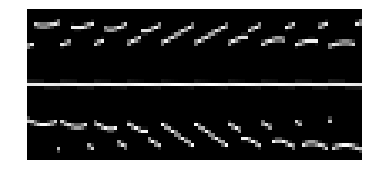

In [49]:
plt.gray()
plt.imshow(construct_X(10,[-33,1,42],15).toarray())
plt.axis('off')